In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
import shap

movies = pd.read_csv('movies_data.csv')

### Feature Engineering :D

In [2]:
def convert_to_list(x):
    if isinstance(x, str) and x.strip():  # Check if x is a non-empty string
        return [item.strip() for item in x.split(',')]
    return ['not listed'] 

# Apply the conversion function to movies and production companies
movies['genres'] = movies['genres'].apply(convert_to_list)
movies['production_companies'] = movies['production_companies'].apply(convert_to_list)
movies.head()

,id,title,release_date,revenue,budget,production_companies,genres,popularity,vote_average,vote_count,overview,reviews,sentiment
0,5,Four Rooms,1995-12-09,4257354,4000000,"[Miramax, A Band Apart]",[Comedy],13.275,5.800,2618,It's Ted the Bellhop's first night on the job....,No reviews available,0.0000
1,6,Judgment Night,1993-10-15,12136938,21000000,"[Largo Entertainment, JVC, Universal Pictures]","[Action, Crime, Thriller]",9.284,6.500,331,"Four young friends, while taking a shortcut en...",No reviews available,0.0000
2,11,Star Wars,1977-05-25,775398007,11000000,"[Lucasfilm Ltd., 20th Century Fox]","[Adventure, Action, Science Fiction]",81.543,8.200,20457,Princess Leia is captured and held hostage by ...,"(As I'm writing this review, Darth Vader's the...",0.9998
3,12,Finding Nemo,2003-05-30,940335536,94000000,[Pixar],"[Animation, Family]",85.328,7.819,19102,"Nemo, an adventurous young clownfish, is unexp...",One of the best animated films I have ever see...,0.9976
4,13,Forrest Gump,1994-06-23,677387716,55000000,"[Paramount Pictures, The Steve Tisch Company, ...","[Comedy, Drama, Romance]",106.538,8.472,27251,A man with a low IQ has accomplished great thi...,Best movie ever. This is the best movie ever! ...,0.9963


### Getting release year/month/week

In [3]:
movies['release_date'] = pd.to_datetime(movies['release_date'])

# Extract year, month, and week number as new columns
movies['release_year'] = movies['release_date'].dt.year
movies['release_month'] = movies['release_date'].dt.month
movies['release_week'] = movies['release_date'].dt.isocalendar().week  # Week number of the year

movies.head()

,id,title,release_date,revenue,budget,production_companies,genres,popularity,vote_average,vote_count,overview,reviews,sentiment,release_year,release_month,release_week
0,5,Four Rooms,1995-12-09,4257354,4000000,"[Miramax, A Band Apart]",[Comedy],13.275,5.800,2618,It's Ted the Bellhop's first night on the job....,No reviews available,0.0000,1995,12,49
1,6,Judgment Night,1993-10-15,12136938,21000000,"[Largo Entertainment, JVC, Universal Pictures]","[Action, Crime, Thriller]",9.284,6.500,331,"Four young friends, while taking a shortcut en...",No reviews available,0.0000,1993,10,41
2,11,Star Wars,1977-05-25,775398007,11000000,"[Lucasfilm Ltd., 20th Century Fox]","[Adventure, Action, Science Fiction]",81.543,8.200,20457,Princess Leia is captured and held hostage by ...,"(As I'm writing this review, Darth Vader's the...",0.9998,1977,5,21
3,12,Finding Nemo,2003-05-30,940335536,94000000,[Pixar],"[Animation, Family]",85.328,7.819,19102,"Nemo, an adventurous young clownfish, is unexp...",One of the best animated films I have ever see...,0.9976,2003,5,22
4,13,Forrest Gump,1994-06-23,677387716,55000000,"[Paramount Pictures, The Steve Tisch Company, ...","[Comedy, Drama, Romance]",106.538,8.472,27251,A man with a low IQ has accomplished great thi...,Best movie ever. This is the best movie ever! ...,0.9963,1994,6,25


#### Time Series plot of total revenue per Month

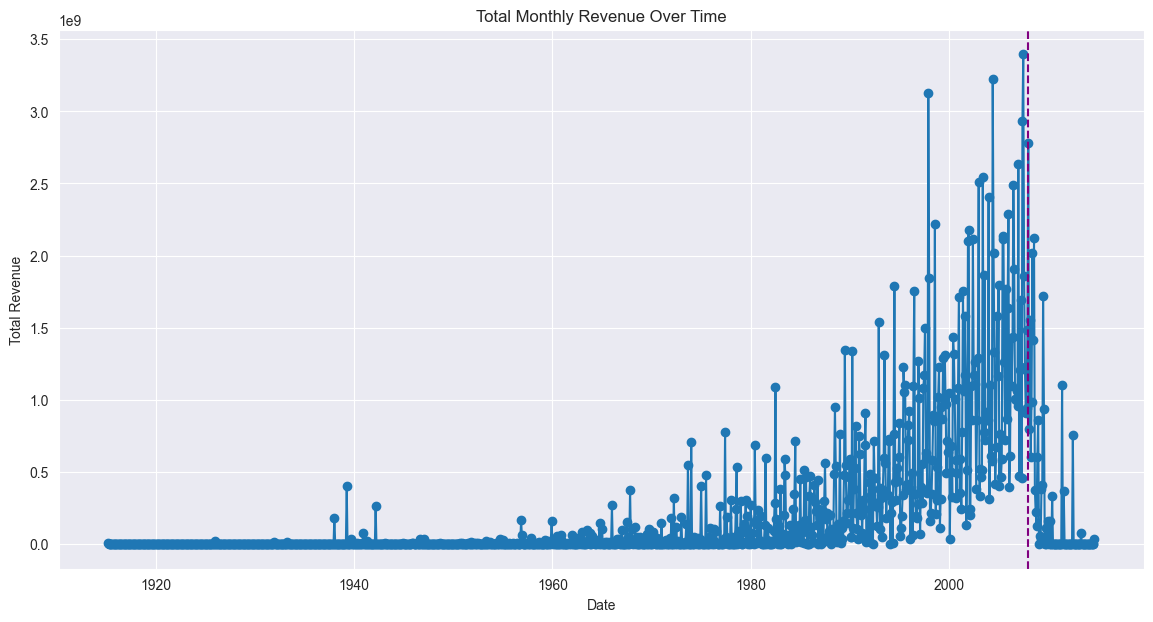

In [4]:
# Set 'release_date' as the index for time series plotting
movies1 = movies.set_index('release_date')

# Resample revenue data by month 
monthly_revenue = movies1['revenue'].resample('ME').sum()  # Sum revenue per month

# Step 4: Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o')
plt.axvline(pd.to_datetime('2008-01-01'), color='purple', linestyle='--', label='2008 Market Crash')
plt.title('Total Monthly Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

#### Line plot of average weekly revenue

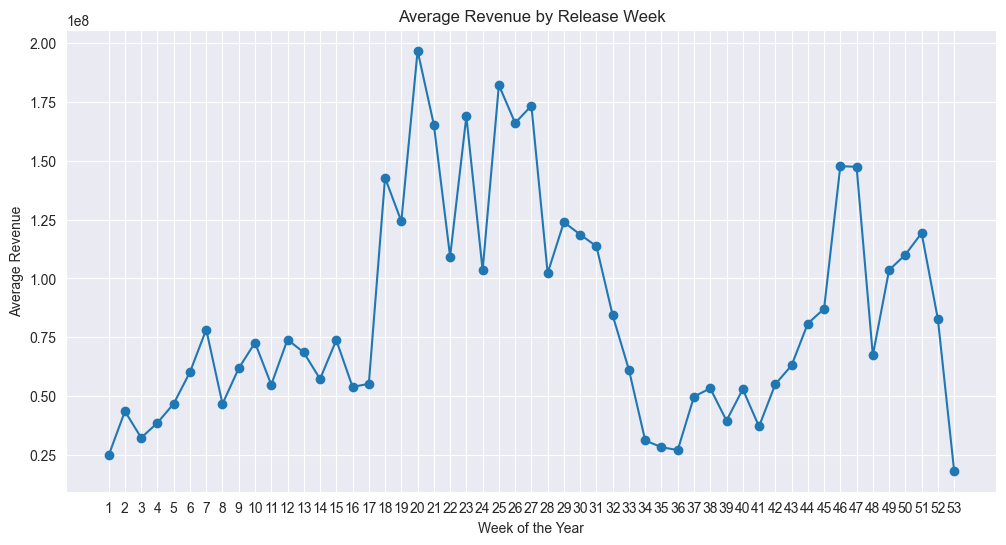

In [5]:
# Calculate average revenue for each week
weekly_revenue = movies.groupby('release_week')['revenue'].mean().reset_index()

# Step 3: Plot the correlation
plt.figure(figsize=(12, 6))
plt.plot(weekly_revenue['release_week'], weekly_revenue['revenue'], marker='o')
plt.title('Average Revenue by Release Week')
plt.xlabel('Week of the Year')
plt.ylabel('Average Revenue')
plt.xticks(range(1, 54))  # Weeks go from 1 to 53 in some years
plt.grid(True)
plt.show()

#### Creating Holiday variables

In [6]:
movies['thanksgiving_release'] = movies['release_week'].isin([46, 47]).astype(int)
movies['christmas_release'] = movies['release_week'].isin([50, 51]).astype(int)

print(f"Christmas movies: {movies['christmas_release'].sum()} \nThanksgiving Movies: {movies['thanksgiving_release'].sum()}")

Christmas movies: 210 
Thanksgiving Movies: 113


### Creating Production level: Based on average revenue and number of movies produced

In [7]:
# Step 1: Explode the 'production_companies' column and calculate average revenue and movie count
movies_exploded = movies.explode('production_companies')
company_stats = movies_exploded.groupby('production_companies').agg(
    avg_revenue=('revenue', 'mean'),
    movie_count=('production_companies', 'count')
).reset_index()

# Step 2: Apply log transformation to the revenue and movie count
company_stats['log_avg_revenue'] = np.log1p(company_stats['avg_revenue'])  # log(1 + revenue) to avoid log(0)
company_stats['log_movie_count'] = np.log1p(company_stats['movie_count'])  # log(1 + count) to handle 0s

# Step 3: Standardize the log-transformed features to balance their scale
scaler = StandardScaler()
company_stats[['log_avg_revenue', 'log_movie_count']] = scaler.fit_transform(company_stats[['log_avg_revenue', 'log_movie_count']])

# Step 4: Calculate the combined score based on standardized log-transformed revenue and movie count
alpha = 0.5  # Revenue weight
beta = 0.5  # Movie count weight
company_stats['score'] = alpha * company_stats['log_avg_revenue'] + beta * company_stats['log_movie_count']

# Step 5: Rank companies based on score and assign levels
top_threshold = company_stats['score'].quantile(0.95)  # Top 5% as top companies
mid_threshold = company_stats['score'].quantile(0.6)  # Middle 35% as mid-level companies

def classify_company(score):
    if score >= top_threshold:
        return 'Top-level'
    elif score >= mid_threshold:
        return 'Mid-level'
    else:
        return 'Low-level'

company_stats['production_level'] = company_stats['score'].apply(classify_company)

# Create a dictionary to map each company to its production level
production_level_map = company_stats.set_index('production_companies')['production_level'].to_dict()

# Step 6: Implement weighted average approach for categorizing movies based on their production companies
def weighted_average_level(companies):
    levels = [production_level_map.get(company, 'Low-level') for company in companies]
    
    # Assign numerical values for each level (Top-level: 3, Mid-level: 2, Low-level: 1)
    level_values = {'Top-level': 3, 'Mid-level': 2, 'Low-level': 1}
    numeric_levels = [level_values[level] for level in levels]

    # Compute the weighted average of levels for all companies
    avg_level = sum(numeric_levels) / len(numeric_levels) if numeric_levels else 1  # Default to 'Low-level' if no valid companies

    # Classify based on average level
    if avg_level >= 2.8:
        return 'Top'
    elif avg_level >= 2.0:
        return 'Mid'
    else:
        return 'Low'

# Step 7: Apply the weighted average approach to each movie
movies['production_level'] = movies['production_companies'].apply(weighted_average_level)

# View the top 20 companies and their production levels
movies.head()

,id,title,release_date,revenue,budget,production_companies,genres,popularity,vote_average,vote_count,overview,reviews,sentiment,release_year,release_month,release_week,thanksgiving_release,christmas_release,production_level
0,5,Four Rooms,1995-12-09,4257354,4000000,"[Miramax, A Band Apart]",[Comedy],13.275,5.800,2618,It's Ted the Bellhop's first night on the job....,No reviews available,0.0000,1995,12,49,0,0,Mid
1,6,Judgment Night,1993-10-15,12136938,21000000,"[Largo Entertainment, JVC, Universal Pictures]","[Action, Crime, Thriller]",9.284,6.500,331,"Four young friends, while taking a shortcut en...",No reviews available,0.0000,1993,10,41,0,0,Mid
2,11,Star Wars,1977-05-25,775398007,11000000,"[Lucasfilm Ltd., 20th Century Fox]","[Adventure, Action, Science Fiction]",81.543,8.200,20457,Princess Leia is captured and held hostage by ...,"(As I'm writing this review, Darth Vader's the...",0.9998,1977,5,21,0,0,Top
3,12,Finding Nemo,2003-05-30,940335536,94000000,[Pixar],"[Animation, Family]",85.328,7.819,19102,"Nemo, an adventurous young clownfish, is unexp...",One of the best animated films I have ever see...,0.9976,2003,5,22,0,0,Top
4,13,Forrest Gump,1994-06-23,677387716,55000000,"[Paramount Pictures, The Steve Tisch Company, ...","[Comedy, Drama, Romance]",106.538,8.472,27251,A man with a low IQ has accomplished great thi...,Best movie ever. This is the best movie ever! ...,0.9963,1994,6,25,0,0,Mid


In [8]:
production_summary = movies.groupby('production_level').agg(
    total_revenue=('revenue', 'mean'),
    movie_count=('revenue', 'count')
).reset_index()

# Step 2: Display the summary
print(production_summary)

  production_level  total_revenue  movie_count
0              Low   1.265212e+07          651
1              Mid   9.608925e+07         1394
2              Top   1.651170e+08          575


In [9]:
movies['log_revenue'] = np.log1p(movies['revenue'])
movies['log_budget'] = np.log1p(movies['budget'])

#### Log Revenue Standard Deviation

In [10]:
movies['log_revenue'].std()

2.261643717524976

### Fitting a Random Forest Pipeline

In [11]:
# Step 1: Fit the MultiLabelBinarizer on the genres data (on the entire dataset)
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])

# Create a DataFrame from the encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=movies.index)

# Concatenate the genre DataFrame with the original dataset
movies = pd.concat([movies, genres_df], axis=1)

In [12]:
movie_titles = movies['title']
X = movies.drop(columns=['revenue', 'budget','title', 'id', 'overview', 'reviews', 'genres', 'release_date'])  # Features
y = movies['log_revenue']  # Target

# Define the categorical and numerical columns
categorical_cols = ['production_level']  # Only 'production_level' as a categorical variable
numerical_cols = ['log_budget', 'popularity', 'vote_average', 'vote_count', 'sentiment','release_year', 'release_month', 'release_week', 'thanksgiving_release', 'christmas_release'] + list(mlb.classes_)

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numeric features
        ('cat', OneHotEncoder(), categorical_cols),  # One-hot encode categorical features
    ])

# Define the model pipeline
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators= 200, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
model_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = model_rf.predict(X_test)

# Calculate Mean Squared Error
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)  

print(f'Root Mean Squared Error (Random Forest): {rmse_rf}')

Root Mean Squared Error (Random Forest): 1.351570866026845


### Fitting a Ridge/Lasso/EN Pipeline

In [13]:
model_ridgecv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV())
])
# Fit the pipeline to the training data
model_ridgecv.fit(X_train, y_train)

# Predict on the test set
y_pred_ridgecv = model_ridgecv.predict(X_test)

# Calculate Root Mean Squared Error
rmse_ridgecv = root_mean_squared_error(y_test, y_pred_ridgecv)

print(f'Root Mean Squared Error (RidgeCV): {rmse_ridgecv}')

Root Mean Squared Error (RidgeCV): 1.5778978672547257


In [14]:
model_lassocv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV())
])
# Fit the pipeline to the training data
model_lassocv.fit(X_train, y_train)

# Predict on the test set
y_pred_lassocv = model_lassocv.predict(X_test)

# Calculate Root Mean Squared Error
rmse_lassocv = root_mean_squared_error(y_test, y_pred_lassocv)

print(f'Root Mean Squared Error (LassoCV): {rmse_lassocv}')

Root Mean Squared Error (LassoCV): 1.5738649945594265


In [15]:
model_encv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNetCV())
])
# Fit the pipeline to the training data
model_encv.fit(X_train, y_train)

# Predict on the test set
y_pred_encv = model_encv.predict(X_test)

# Calculate Root Mean Squared Error
rmse_encv = root_mean_squared_error(y_test, y_pred_encv)

print(f'Root Mean Squared Error (ElasticNetCV): {rmse_encv}')

Root Mean Squared Error (ElasticNetCV): 1.5749064764564746


### XGBoost

In [16]:
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=300,      # Number of boosting rounds
        learning_rate=0.05,     # Step size shrinkage
        max_depth= 6,           # Maximum depth of a tree
        subsample=0.8,         # Fraction of samples used for training
        colsample_bytree=0.8,  # Fraction of features used for training
        reg_alpha=0.1,         # L1 regularization (sparsity)
        reg_lambda=1.0,        # L2 regularization (ridge-like penalty)
        random_state=42        # For reproducibility
    ))
])

# Fit the pipeline to the training data
model_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Calculate Root Mean Squared Error
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)

print(f'Root Mean Squared Error (XGBoost): {rmse_xgb}')

Root Mean Squared Error (XGBoost): 1.3167931334571632


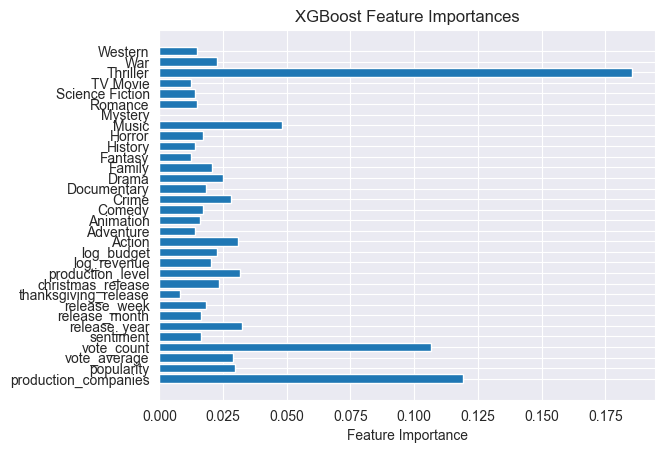

In [17]:
import matplotlib.pyplot as plt

xgb_regressor = model_xgb.named_steps['regressor']
xgb_importances = xgb_regressor.feature_importances_

plt.barh(X_train.columns, xgb_importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()

### Fitting an SVM 

In [18]:
model_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C = 5, epsilon = .5))
])

model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)

rmse_svm = root_mean_squared_error(y_test, y_pred_svm)

print(f'Root Mean Squared Log Error (SVM): {rmse_svm}')

Root Mean Squared Log Error (SVM): 1.488193094212664


### Fitting an RNN

In [19]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Reshape data for RNN (RNN expects [samples, timesteps, features])
X_train_processed = X_train_processed.reshape((X_train_processed.shape[0], 1, X_train_processed.shape[1]))
X_test_processed = X_test_processed.reshape((X_test_processed.shape[0], 1, X_test_processed.shape[1]))

# Define the RNN model
model_rnn = Sequential()

# Add a SimpleRNN layer (you can experiment with units)
model_rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train_processed.shape[1], X_train_processed.shape[2])))

# Add a Dropout layer to prevent overfitting
model_rnn.add(Dropout(0.5))

# Add a Dense layer for the output (1 output value for regression)
model_rnn.add(Dense(1))

# Compile the model with Mean Squared Logarithmic Error as loss function for regression
model_rnn.compile(optimizer=Adam(), loss='mean_squared_logarithmic_error')

# Train the RNN model
model_rnn.fit(X_train_processed, y_train, epochs= 100, batch_size= 32, validation_data=(X_test_processed, y_test))

# Predict on the test set
y_pred_rnn = model_rnn.predict(X_test_processed)

# Calculate Root Mean Squared Log Error (RMSLE)
rmse_rnn = root_mean_squared_error(y_test, y_pred_rnn)

print(f'Root Mean Squared Log Error (RNN): {rmse_rnn}')

C:\Users\jessa\anaconda3\envs\stat486\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.1109 - val_loss: 2.1398
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0975 - val_loss: 1.2383
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2511 - val_loss: 0.7836
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8108 - val_loss: 0.5053
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5833 - val_loss: 0.3306
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4048 - val_loss: 0.2201
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3001 - val_loss: 0.1467
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2276 - val_loss: 0.1003
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1643 - val_loss: 0.0709
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1422 - val_loss: 0.0513
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1257 - val_loss: 0.0393
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

#### Dimenstionality Reduction - PCA

In [20]:
model_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),  # Reduce to 95% variance
    ('regressor', XGBRegressor(
        n_estimators=300,      # Number of boosting rounds
        learning_rate=0.05,     # Step size shrinkage
        max_depth= 6,           # Maximum depth of a tree
        subsample=0.8,         # Fraction of samples used for training
        colsample_bytree=0.8,  # Fraction of features used for training
        reg_alpha=0.1,         # L1 regularization (sparsity)
        reg_lambda=1.0,        # L2 regularization (ridge-like penalty)
        random_state=42        # For reproducibility
    ))  # XGBoost
])

# Fit the model pipeline
model_pca.fit(X_train, y_train)

# Predict on the test set
y_pred_pca = model_pca.predict(X_test)

# Calculate Root Mean Squared Error
rmse_pca = root_mean_squared_error(y_test, y_pred_pca)
print(f'Root Mean Squared Error (PCA + XGBoost): {rmse_pca}')

Root Mean Squared Error (PCA + XGBoost): 1.5730575378057923


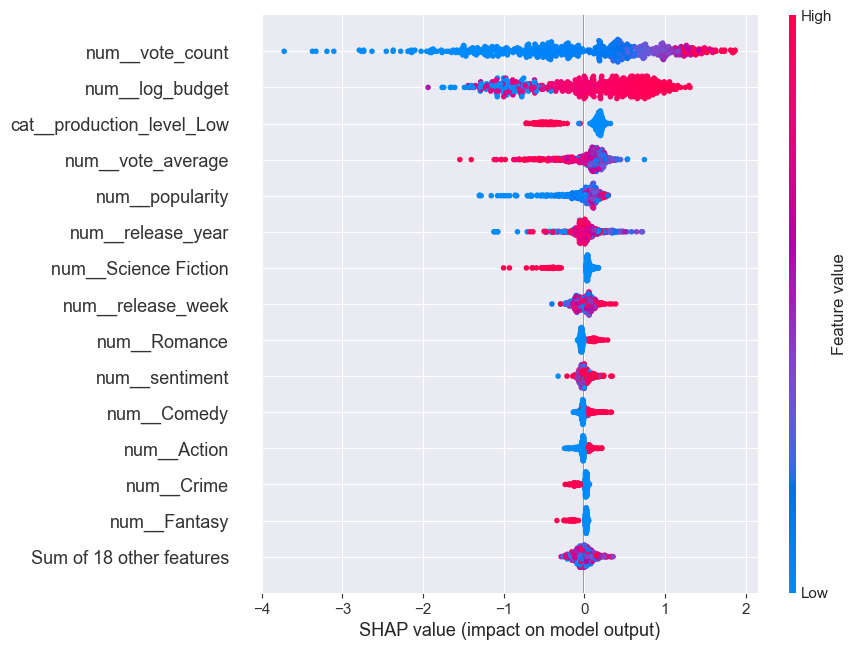

In [21]:
# Step 1: Preprocess the data (using the same transformation as in your pipeline)
X_test_transformed = model_xgb.named_steps['preprocessor'].transform(X_test)

# Step 3: Initialize SHAP Explainer
explainer = shap.Explainer(model_xgb.named_steps['regressor'], X_test_transformed)

# Step 4: Compute SHAP values
shap_values = explainer(X_test_transformed)

# Step 5: Get feature names (these come from the preprocessor pipeline)
# Categorical features will have their one-hot encoded names
# For example, if the 'production_level' has three possible values, 
# the one-hot encoder will create three new features with the original column name and the class labels.
feature_names = model_rf.named_steps['preprocessor'].get_feature_names_out()

# Step 6: Beeswarm plot of top 15 features
exp = shap.Explanation(shap_values.values, shap_values.base_values, X_test_transformed, feature_names=feature_names)

# Visualize top 15 most important features
shap.plots.beeswarm(exp, max_display=15)

# Show the plot
plt.show()

#### Cluster Analysis

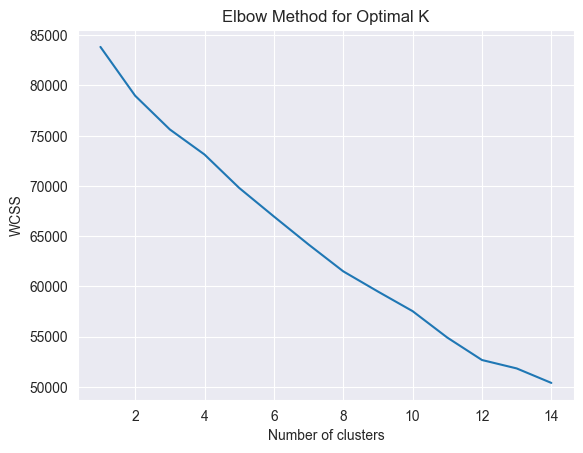

In [22]:
# Scale the features to ensure they are on a similar scale
scaler = StandardScaler()
X_processed = preprocessor.fit_transform(X)
X_scaled = scaler.fit_transform(X_processed)

wcss = []
for i in range(1, 15):  # Test values of K from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to visualize the elbow point
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

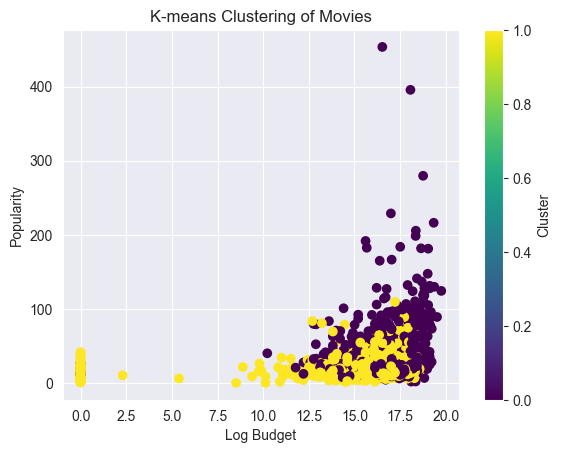

In [35]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  
kmeans.fit(X_scaled)

# Get the cluster labels
movies['cluster'] = kmeans.labels_

# Visualize the clusters (you can use a 2D plot or 3D plot depending on your data)
plt.scatter(movies['log_budget'], movies['popularity'], c=movies['cluster'], cmap='viridis')
plt.xlabel('Log Budget')
plt.ylabel('Popularity')
plt.title('K-means Clustering of Movies')
plt.colorbar(label='Cluster')
plt.show()

In [37]:
# Cluster centers
cluster_centers = kmeans.cluster_centers_

In [38]:
# Get the feature names after one-hot encoding
# This will combine both numerical and categorical feature names
num_feature_names = numerical_cols
cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Create a DataFrame with the cluster centers for better readability
cluster_centers_df = pd.DataFrame(cluster_centers, columns=feature_names)
print(cluster_centers_df)

   log_budget  popularity  vote_average  vote_count  sentiment  release_year  \
0    0.442003    0.453841      0.192704    0.521264   0.434098     -0.009277   
1   -0.296548   -0.304490     -0.129289   -0.349726  -0.291244      0.006224   

   release_month  release_week  thanksgiving_release  christmas_release  ...  \
0       0.439003      0.443331              0.213499           0.359460  ...   
1      -0.294535     -0.297439             -0.143240          -0.241168  ...   

    Mystery   Romance  Science Fiction  TV Movie  Thriller       War  \
0 -0.138037 -0.207985         0.325725  -0.01954 -0.082777  0.084924   
1  0.092611  0.139541        -0.218535   0.01311  0.055536 -0.056977   

    Western  production_level_Low  production_level_Mid  production_level_Top  
0  0.086483             -0.414418              0.086245              0.328709  
1 -0.058023              0.278041             -0.057864             -0.220537  

[2 rows x 32 columns]


### PCA to get Principle componenets for the graph

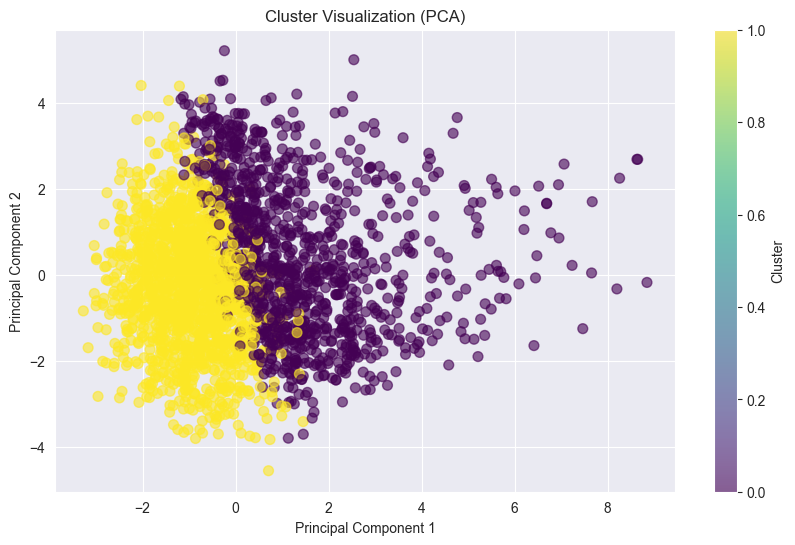

In [36]:
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)  # X_processed is your preprocessed feature set

# Plot the data points, color-coded by cluster
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.6)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()